In [350]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn; seaborn.set()
from sklearn.metrics import mean_squared_error
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [351]:
df = pd.read_csv('EtherPriceHistory(USD).csv')

In [352]:
df[0:5]

Date(UTC)  UnixTimeStamp  Value
0  7/30/2015     1438214400    0.0
1  7/31/2015     1438300800    0.0
2   8/1/2015     1438387200    0.0
3   8/2/2015     1438473600    0.0
4   8/3/2015     1438560000    0.0

In [353]:
#df = pd.read_csv('formatted_datetime_eth_pricedata.csv')
df = df[13:]

In [354]:
date = pd.to_datetime(df['Date(UTC)'])
price = df['Value']

In [355]:
type(date), type(price)

(pandas.core.series.Series, pandas.core.series.Series)

In [356]:
df['Date'] = pd.to_datetime(df['Date(UTC)'],infer_datetime_format=True)
date = df['Date']

In [357]:
price.index = date

In [358]:
len(date), len(price)

(956, 956)

In [359]:
price.index = date

In [360]:
from statsmodels.tsa.arima_model import ARIMA

### now for test train split

In [396]:
price[0:5]

Date
2015-08-12    1.29
2015-08-13    1.88
2015-08-14    1.79
2015-08-15    1.79
2015-08-17    1.30
Name: Value, dtype: float64

In [397]:
len(price)

956

In [362]:
0.7*len(price)

669.1999999999999

### kaggle notebook

In [363]:
max(price)

1385.02

In [364]:
ts_logtransformed = np.log(price)

In [365]:
print(ts_logtransformed[0:5])

Date
2015-08-12    0.254642
2015-08-13    0.631272
2015-08-14    0.582216
2015-08-15    0.582216
2015-08-17    0.262364
Name: Value, dtype: float64


In [366]:
stuff = ts_logtransformed['2017-01-01':]

In [367]:
max(price)

1385.02

In [368]:
stuff2 = price[price == max(price)]

In [369]:
stuff2

Date
2018-01-13    1385.02
Name: Value, dtype: float64

In [398]:
price1 = price['2015-08-12':'2018-01-13']

In [399]:
price2 = price['2018-01-13':]

price1 and price 2 need to go through a test train split

then we will make two models. one for each

this will also have to be done on the differenced 
data due to stationarity

### First price 1

In [400]:
len(price1)

883

In [401]:
#df.replace([np.inf, -np.inf], np.nan)


In [402]:
#price[price == 0.0] = 1e-200
#price = price[13:]

In [403]:
len(price1)

883

ok we need to take price 1 and do a test train split

In [404]:
price1_train = price1[:300]

In [405]:
price1_test = price1[300:]

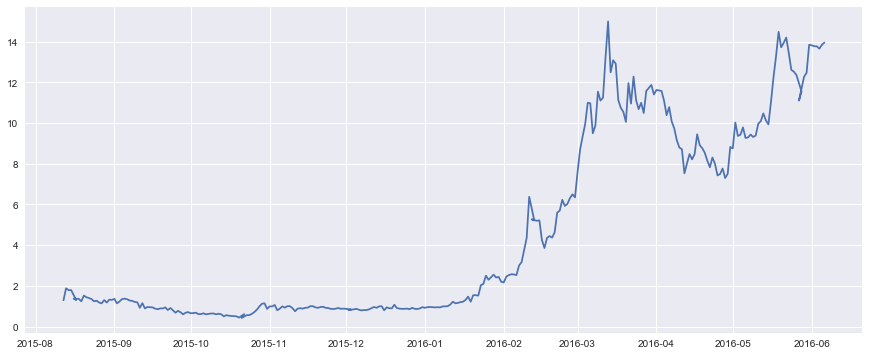

In [406]:
#is it ok if for now i just sliced off the first 13 days? 
#i could do the whole drop na thing
plt.plot(price1_train)

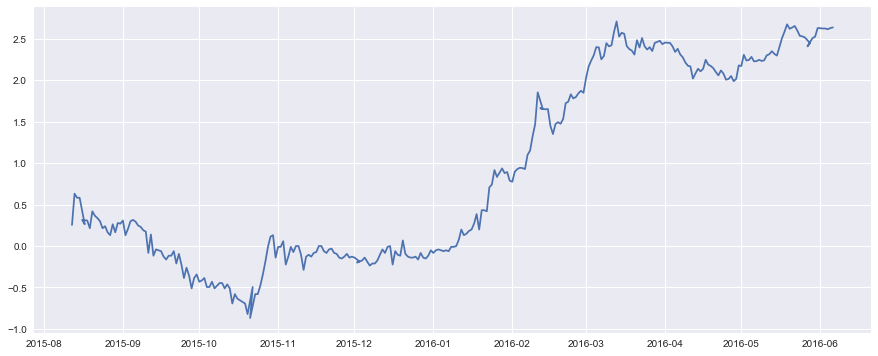

In [407]:
ts_logtransformed = np.log(price1_train)
plt.plot(ts_logtransformed)

### Rolling Mean

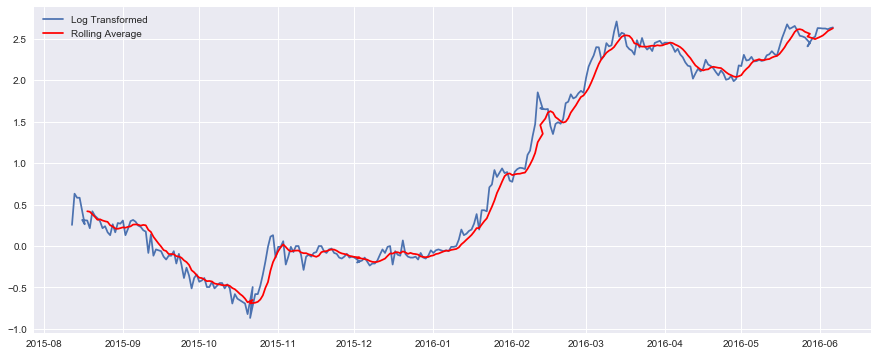

In [408]:
Rolling_average = ts_logtransformed.rolling(window = 7, center= False).mean()
plt.plot(ts_logtransformed, label = 'Log Transformed')
plt.plot(Rolling_average, color = 'red', label = 'Rolling Average')
plt.legend(loc = 'best')

In [409]:
log_Rolling_difference = ts_logtransformed - Rolling_average
log_Rolling_difference.head(10)
log_Rolling_difference.tail(10)

Date
2016-05-27   -0.118869
2016-05-29    0.002110
2016-05-30    0.028959
2016-05-31    0.119831
2016-06-01    0.104284
2016-06-02    0.085241
2016-06-03    0.060146
2016-06-04    0.021881
2016-06-05    0.018507
2016-06-06    0.010408
Name: Value, dtype: float64

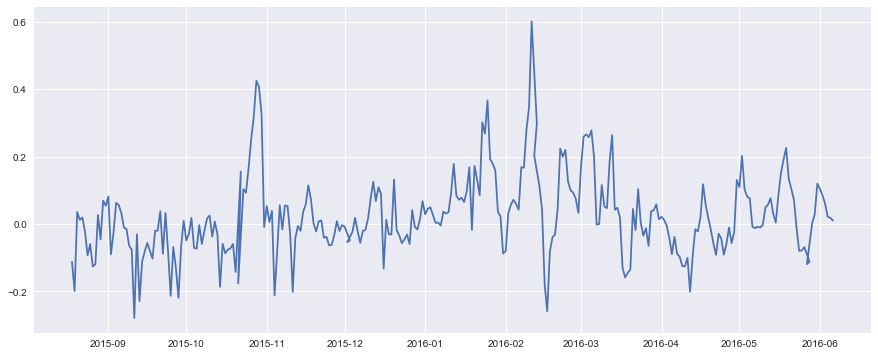

In [410]:
log_Rolling_difference.dropna(inplace=True)
plt.plot(log_Rolling_difference)

In [411]:
test_for_stationary(log_Rolling_difference)

NameError: name 'test_for_stationary' is not defined

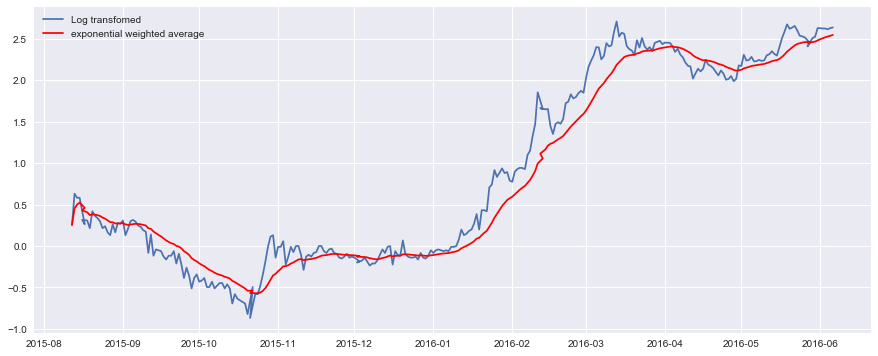

In [412]:
expwighted_avg = ts_logtransformed.ewm(halflife=7,min_periods=0,adjust=True,ignore_na=False).mean()
plt.plot(ts_logtransformed, label = 'Log transfomed')
plt.plot(expwighted_avg, color='red', label = 'exponential weighted average')
plt.legend(loc = 'best')

In [413]:
log_expmovwt_diff = ts_logtransformed - expwighted_avg

### Seasonality Adjustment by Differencing

Date
2015-08-12         NaN
2015-08-13         NaN
2015-08-14         NaN
2015-08-15         NaN
2015-08-17         NaN
2015-08-16         NaN
2015-08-18         NaN
2015-08-19   -0.039531
2015-08-20   -0.212561
2015-08-21   -0.217573
Name: Value, dtype: float64

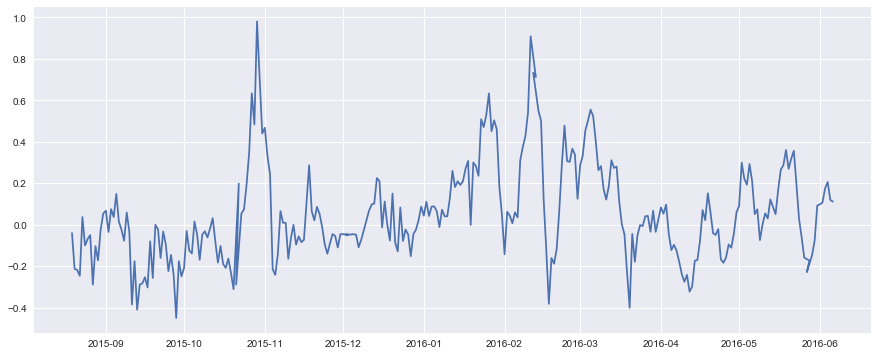

In [414]:
ts_diff_logtrans = ts_logtransformed -ts_logtransformed.shift(7) #implies 7 days
plt.plot(ts_diff_logtrans)
ts_diff_logtrans.head(10) #thats why there are nans for first 7

In [415]:
ts_diff_logtrans = ts_diff_logtrans[8:]

In [416]:
ts_diff_logtrans = ts_diff_logtrans.fillna(0)

### decomposition

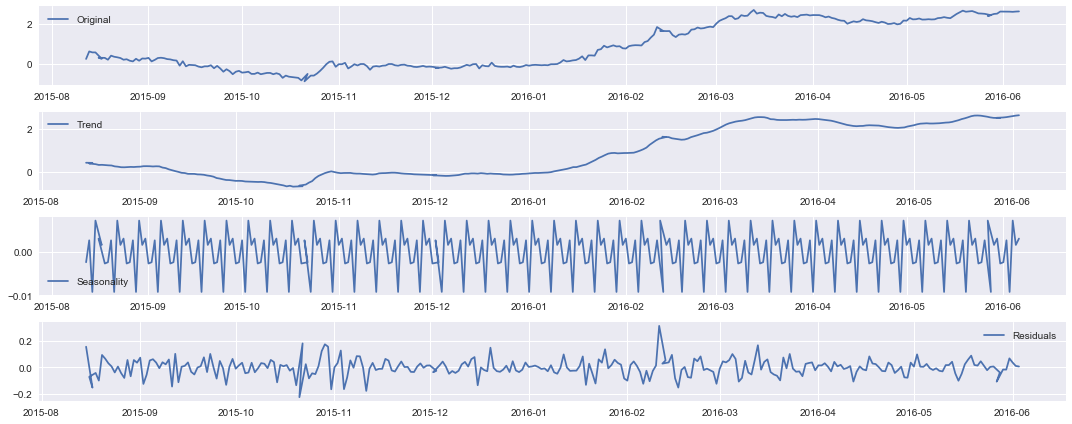

In [417]:
#done on log(price)
decomposition = seasonal_decompose(ts_logtransformed, freq=7) #seasonal period.

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid 
#im gonna break these up into 3 components
#take the original, subtract of trend subract off seasonal, 
#whatever is left is residual
#aka noise

plt.subplot(411)
plt.plot(ts_logtransformed, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
#then plotted, frist is original, second is trend, third is seanoality, 4th is residuals

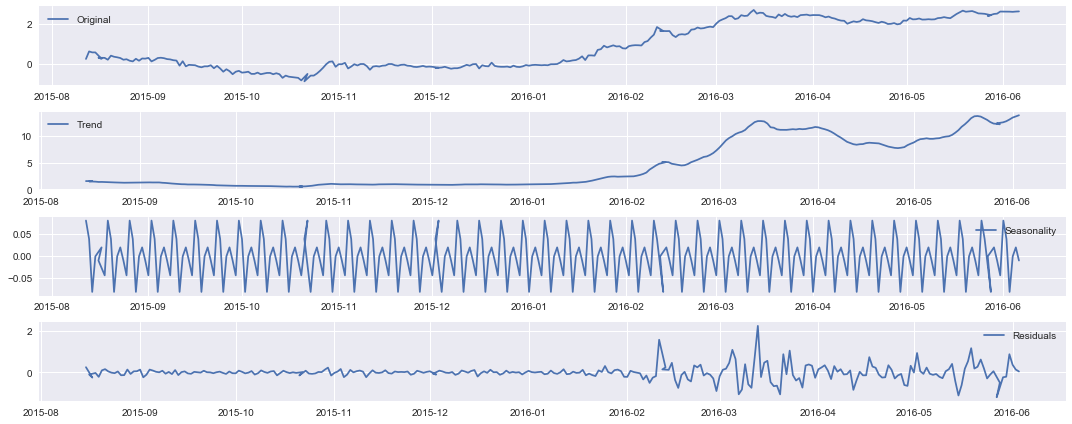

In [418]:
#done on price data
decomposition = seasonal_decompose(price1_train, freq=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_logtransformed, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Forecasting

In [419]:
#ACF and PACF plots:
lag_acf = acf(ts_diff_logtrans, nlags=30)
lag_pacf = pacf(ts_diff_logtrans, nlags=50, method='ols')

Text(0.5,1,'Autocorrelation Function')

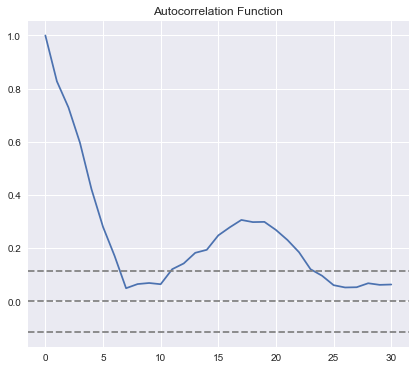

In [420]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff_logtrans)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff_logtrans)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

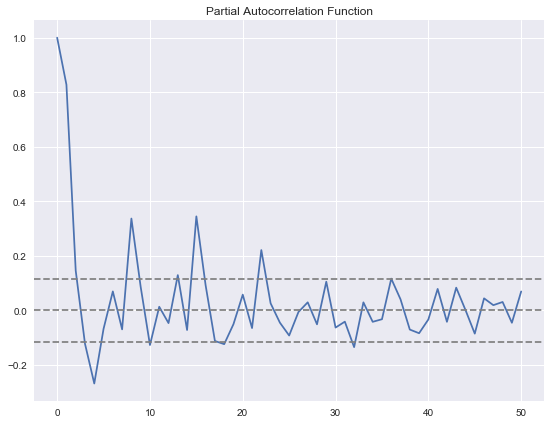

In [421]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff_logtrans)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff_logtrans)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

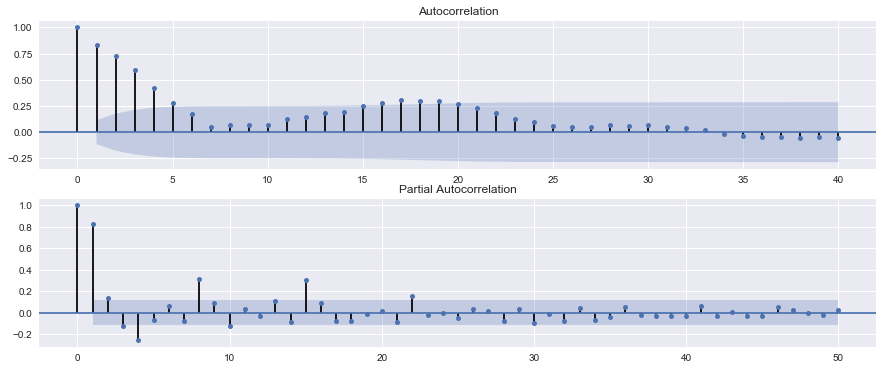

In [422]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts_diff_logtrans, ax=pyplot.gca(),lags=40)
pyplot.subplot(212)
plot_pacf(ts_diff_logtrans, ax=pyplot.gca(), lags=50)
pyplot.show()

### directly comparing  and applying the method and reasoning: from the kaggle bitcoin notebook, to ethereum data.

Below are some observations from the plots.

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. (the blue region) These can be used to determine the ‚Äòp‚Äô and ‚Äòq‚Äô values as: the Lag values are identified from PACF and ACF plots for Autoregression(AR) and Moving Average(MA) parameters, p and q respectively p ‚Äì The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=3, The PACF shows a significant lag on day 2.

q ‚Äì The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=7,(q = 25 if we look at higher graph) since the ACF shows a significant lag for 7th day.

### Do Dickey Fuller test for stationarity

In [423]:
from statsmodels.tsa.stattools import adfuller


adfuller1 = adfuller(ts_diff_logtrans)
print(adfuller1)

(-2.1149751818531213, 0.23853579657646368, 16, 275, {'1%': -3.454355055831705, '5%': -2.8721080938842976, '10%': -2.572401325619835}, -437.3489865586946)


In [424]:
adfuller2 = adfuller(ts_logtransformed)
print(adfuller2)

(0.24451306212907817, 0.974650555760738, 6, 293, {'1%': -3.452867117291862, '5%': -2.8714554160827745, '10%': -2.5720532321867466}, -538.4361685144361)


In [140]:
adfuller2

(-1.008284833681087,
 0.7502306173204721,
 20,
 935,
 {'1%': -3.437363201927513,
  '10%': -2.5684185607252137,
  '5%': -2.864636122077874},
 -2155.2223361770425)

2nd value p-value is 0.75
The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.
so in ur case ist > 0.05 so we cannot reject the null hypothesis
which means ur series has a unit root
now check https://en.wikipedia.org/wiki/Unit_root_test
oh that means it is not stationary?
ugh
the gist is if ur series has a unit root its not statinary
yeah üòê
so doesnt matter what else you get
because "A common assumption in many time series techniques is that the data are stationary. A stationary process has the property that the mean, variance and autocorrelation structure do not change over time"
if this gets violated nothing else matters

we need to use the stationary log transformed.

yeah whichever series gives u a p-value (2nd value in that adfuller) < 0.05 -
use that one and do everything on that -
also the process we just followed, you can leverage that in the future for some function and to interpret its results esepcially if its a bit complex like this one -
ok.. just wondering for when i do the predicting...what will i be predicting? -
the price itself and u can match it with the log diff of the series
u can get back the original price anyway after doing an inverse transform - 
so will i be predicting a new "log_diff_trans" and then reverse transforming that data to get price back? -
yes but only if the series is stationary when you trained the model (after applying the transformations and doing the ad fuller test) - 
refer to https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/ - 
in this case they do some seasonal differncing also to make it stationary so he mentions the same, "For reference, the seasonal difference operation can be inverted by adding the observation for the same month the year before. This is needed in the case that predictions are made by a model fit on seasonally differenced data. "

In [129]:
model = ARIMA(ts_diff_logtrans, order=(2, 1, 25))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q =25')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

^^hmm interesting error

### Testing out different parameters:
note: done on tsdifflogtrans vs ts_logtransformed... ACF and PACF were done on diff, so it makes sense to train the model on diff

/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


AIC: 
-2112.3310059190344


/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


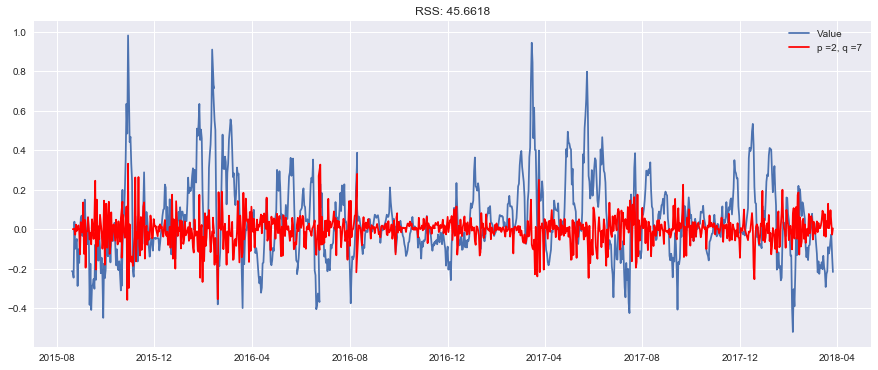

In [130]:
model = ARIMA(ts_diff_logtrans, order=(2, 1, 7))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q =7')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print("AIC: ")
print(results_ARIMA.aic)

/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


AIC: 
-2117.109190378026


/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


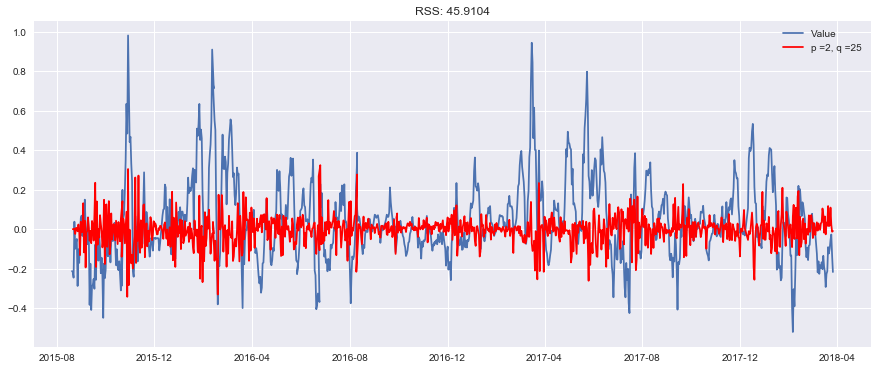

In [131]:
model = ARIMA(ts_diff_logtrans, order=(2, 1, 8))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q =25')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print("AIC: ")
print(results_ARIMA.aic)

/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


AIC: 
-2102.8427258743095


/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


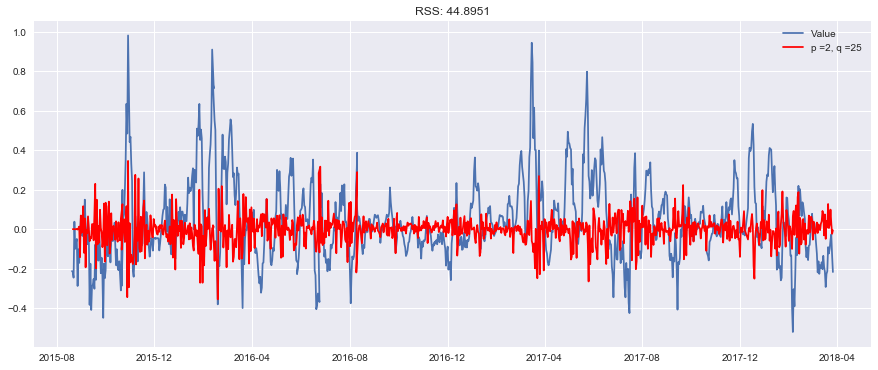

In [132]:
model = ARIMA(ts_diff_logtrans, order=(2, 1, 9))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q =25')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print("AIC: ")
print(results_ARIMA.aic)

/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


AIC: 
-2107.33254748714


/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


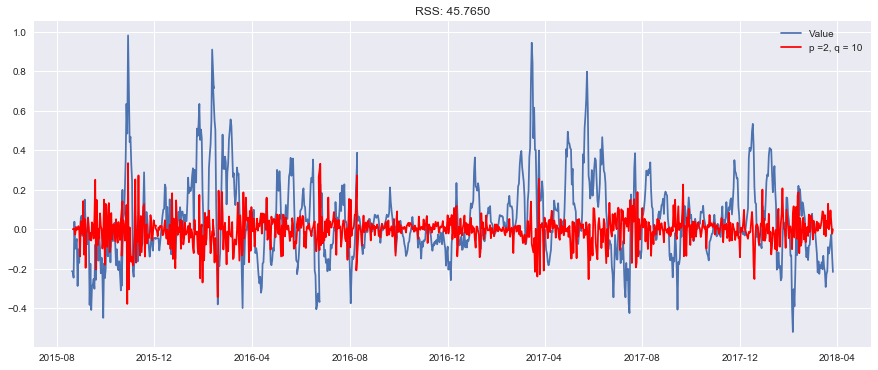

In [133]:
model = ARIMA(ts_diff_logtrans, order=(2, 1, 10))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q = 10')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print("AIC: ")
print(results_ARIMA.aic)

/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed t

AIC: 
-2101.277072644969


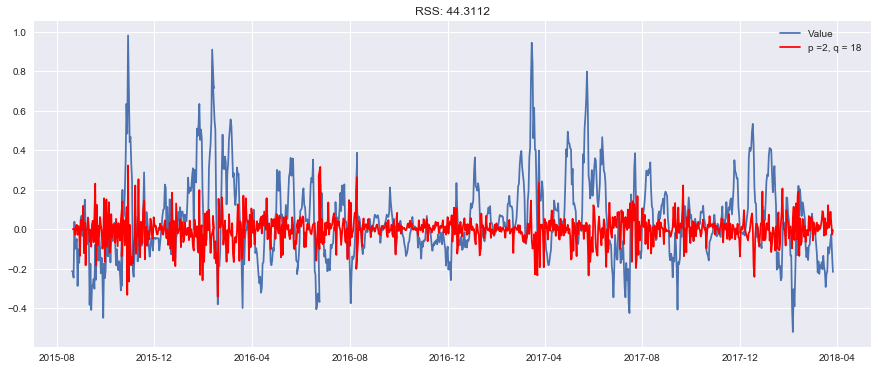

In [134]:
model = ARIMA(ts_diff_logtrans, order=(2, 1, 18))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q = 18')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print("AIC: ")
print(results_ARIMA.aic)

In [135]:
model = ARIMA(ts_diff_logtrans, order=(2, 1, 19))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q = 19')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print("AIC: ")
print(results_ARIMA.aic)

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

## these are ts_logtransformed

In [136]:
model2 = ARIMA(ts_logtransformed, order=(2, 1, 9))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q =25')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans #minus the ts_logtransformed?
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print(results_ARIMA.aic)


ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [137]:
model2 = ARIMA(ts_logtransformed, order=(2, 1, 10))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q =10')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans #minus the ts_logtransformed?
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print("AIC:")
print(results_ARIMA.aic)

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


AIC:
-2159.3041014056103


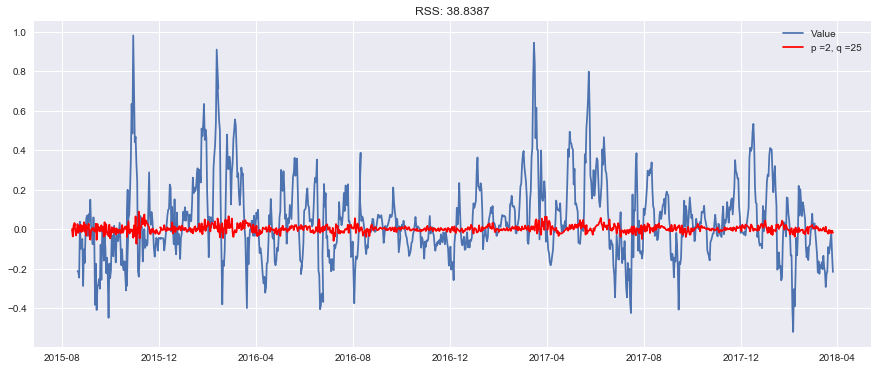

In [138]:
model = ARIMA(ts_logtransformed, order=(2, 1, 19))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q =25')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans #minus the ts_logtransformed?
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print("AIC:")
print(results_ARIMA.aic)

#probably do model.predict(test_data)

In [139]:
model = ARIMA(ts_logtransformed, order=(2, 1, 25))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q =25')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans #minus the ts_logtransformed?
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print(results_ARIMA.aic)

/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Alexandra/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


KeyboardInterrupt: 

In [ ]:
model = ARIMA(ts_logtransformed, order=(2, 1, 20))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q =25')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans #minus the ts_logtransformed?
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print(results_ARIMA.aic)

In [ ]:
model = ARIMA(ts_logtransformed, order=(2, 1, 18))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q =18')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans #minus the ts_logtransformed?
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print("AIC: ")
print(results_ARIMA.aic)

In [ ]:
model = ARIMA(ts_logtransformed, order=(2, 1, 27))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q =18')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans #minus the ts_logtransformed?
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')
print("AIC: ")
print(results_ARIMA.aic)

#### extra stuff checking logtransformed most likely not needed most likely a typo

In [96]:
ts_logtransformed = ts_logtransformed.fillna(0)

In [221]:
model = ARIMA(ts_logtransformed, order=(2, 1, 8))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q =25')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans #minus the ts_logtransformed?
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [222]:
model = ARIMA(log_expmovwt_diff, order=(2, 1, 7))  
results_ARIMA = model.fit(trend= 'nc', disp=-1)  
plt.plot(ts_diff_logtrans)
plt.plot(results_ARIMA.fittedvalues, color='red', label = 'p =2, q =25')
RSS =results_ARIMA.fittedvalues-ts_diff_logtrans
RSS.dropna(inplace=True)
plt.title('RSS: %.4f'% sum(RSS**2))
plt.legend(loc='best')

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.